In [1]:
import pickle
import random
import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers
from scipy.stats import ortho_group
import progressbar

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL

from IPython import display

# 读入数据

In [2]:
pickle_file = 'spsi_dataset.pkl'

f = open(pickle_file, 'rb')
save = pickle.load(f)
structure = np.array(save['structure'], dtype='float32')
signature = np.array(save['signature'], dtype='int32')

# 缩放至 [-1,1]
structure = np.interp(structure, (-2.5, 2.5), (-1, 1))
structure = np.array(structure, dtype='float32')

print('structure:', structure.shape, structure.dtype)
print('signature:', signature.shape, signature.dtype)

structure: (17280, 12, 3) float32
signature: (17280,) int32


In [3]:
new_stru = np.zeros((90000,12,3), dtype='float32')
new_sign = np.zeros((90000,), dtype='int32')

sig_0,sig_1,sig_2 = 0, 0, 0
index = 0
bar = progressbar.ProgressBar(max_value=90000)
while index != 90000:
    idx = random.randint(0,17279)
    ortho_mat = np.float32(ortho_group.rvs(dim=3))
    if signature[idx]==0 and sig_0 != 30000:
        new_stru[index] = structure[idx] @ ortho_mat
        new_sign[index] = signature[idx]
        sig_0 += 1
        index += 1
    if signature[idx]==1 and sig_1 != 30000:
        new_stru[index] = structure[idx] @ ortho_mat
        new_sign[index] = signature[idx]
        sig_1 += 1
        index += 1
    if signature[idx]==2 and sig_2 != 30000:
        new_stru[index] = structure[idx] @ ortho_mat
        new_sign[index] = signature[idx]
        sig_2 += 1
        index += 1
    bar.update(index)

 99% (89934 of 90000) |################# | Elapsed Time: 0:00:37 ETA:   0:00:00

In [4]:
print(sig_0, sig_1, sig_2)

30000 30000 30000


In [5]:
structure = new_stru
signature = new_sign

# 增加一维
structure = np.expand_dims(structure, axis=-1)
# 独热编码
signature = tf.one_hot(signature, 3)

print('structure:', structure.shape, structure.dtype)
print('signature:', signature.shape, signature.dtype)

structure: (90000, 12, 3, 1) float32
signature: (90000, 3) <dtype: 'float32'>


In [6]:
print(structure[-1])

[[[-0.40342087]
  [-0.69024324]
  [ 0.03423714]]

 [[-0.7127956 ]
  [ 0.2854401 ]
  [ 0.22620204]]

 [[-0.23460631]
  [ 0.39754784]
  [-0.6537254 ]]

 [[-0.884083  ]
  [-0.13283259]
  [-0.4341137 ]]

 [[-0.16955715]
  [-0.4011623 ]
  [-0.67413247]]

 [[-0.22996904]
  [-0.29211608]
  [ 0.70888764]]

 [[ 0.5502993 ]
  [ 0.45071462]
  [-0.36665404]]

 [[ 0.1599344 ]
  [ 0.4069049 ]
  [ 0.70240694]]

 [[-0.08465156]
  [ 0.80019116]
  [ 0.02187194]]

 [[ 0.7524608 ]
  [ 0.04377631]
  [ 0.29288402]]

 [[ 0.5928825 ]
  [-0.36069056]
  [-0.4020027 ]]

 [[ 0.3604633 ]
  [-0.6546436 ]
  [ 0.30490395]]]


In [7]:
print(signature[-1])

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


# 构造模型

In [8]:
# 超参数
batch_size = 100
input_shape=(12,3,1)

In [14]:
# point net
inputs = layers.Input(shape=input_shape)

# transform net
transform = layers.BatchNormalization()(inputs)
transform = layers.Conv2D(filters=16, kernel_size=(1,3), strides=1, padding="valid", activation='relu')(transform)

transform = layers.BatchNormalization()(transform)
transform = layers.Conv2D(filters=32, kernel_size=(1,1), strides=1, padding="valid", activation='relu')(transform)

transform = layers.BatchNormalization()(transform)
transform = layers.Conv2D(filters=64, kernel_size=(1,1), strides=1, padding="valid", activation='relu')(transform)

transform = layers.MaxPool2D(pool_size=(12,1), padding='valid')(transform)
transform = layers.Flatten()(transform)

transform = layers.BatchNormalization()(transform)
transform = layers.Dense(units=32, activation='relu')(transform)
transform = layers.Dropout(rate=0.3)(transform)

transform = layers.BatchNormalization()(transform)
transform = layers.Dense(units=16, activation='relu')(transform)
transform = layers.Dropout(rate=0.3)(transform)

transform = layers.Dense(units=9, kernel_initializer=tf.constant_initializer(0.0), bias_initializer=tf.constant_initializer(0.0))(transform)
transform = tf.nn.bias_add(transform, np.eye(3).flatten())

transform = layers.Reshape(target_shape=(3,3), name='transform_output')(transform)

# apply itn
network = tf.matmul(tf.squeeze(inputs, axis=-1), transform)
network = tf.expand_dims(network, axis=-1)

# mlp(32,32)
network = layers.BatchNormalization()(network)
network = layers.Conv2D(filters=16, kernel_size=(1,3), strides=1, padding="valid", activation='relu')(network)

network = layers.BatchNormalization()(network)
network = layers.Conv2D(filters=32, kernel_size=(1,1), strides=1, padding="valid", activation='relu')(network)

network = layers.BatchNormalization()(network)
network = layers.Conv2D(filters=64, kernel_size=(1,1), strides=1, padding="valid", activation='relu')(network)

network = layers.MaxPool2D(pool_size=(12,1), padding='valid')(network)

network = layers.Flatten()(network)

network = layers.BatchNormalization()(network)
network = layers.Dense(units=32, activation='relu')(network)
network = layers.Dropout(rate=0.3)(network)

network = layers.BatchNormalization()(network)
network = layers.Dense(units=16, activation='relu')(network)
network = layers.Dropout(rate=0.3)(network)

network = layers.BatchNormalization()(network)
logits = layers.Dense(units=3, name='logits_output')(network)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12, 3, 1)]   0                                            
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 12, 3, 1)     4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 12, 1, 16)    64          batch_normalization_7[0][0]      
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 12, 1, 16)    64          conv2d_4[0][0]                   
____________________________________________________________________________________________

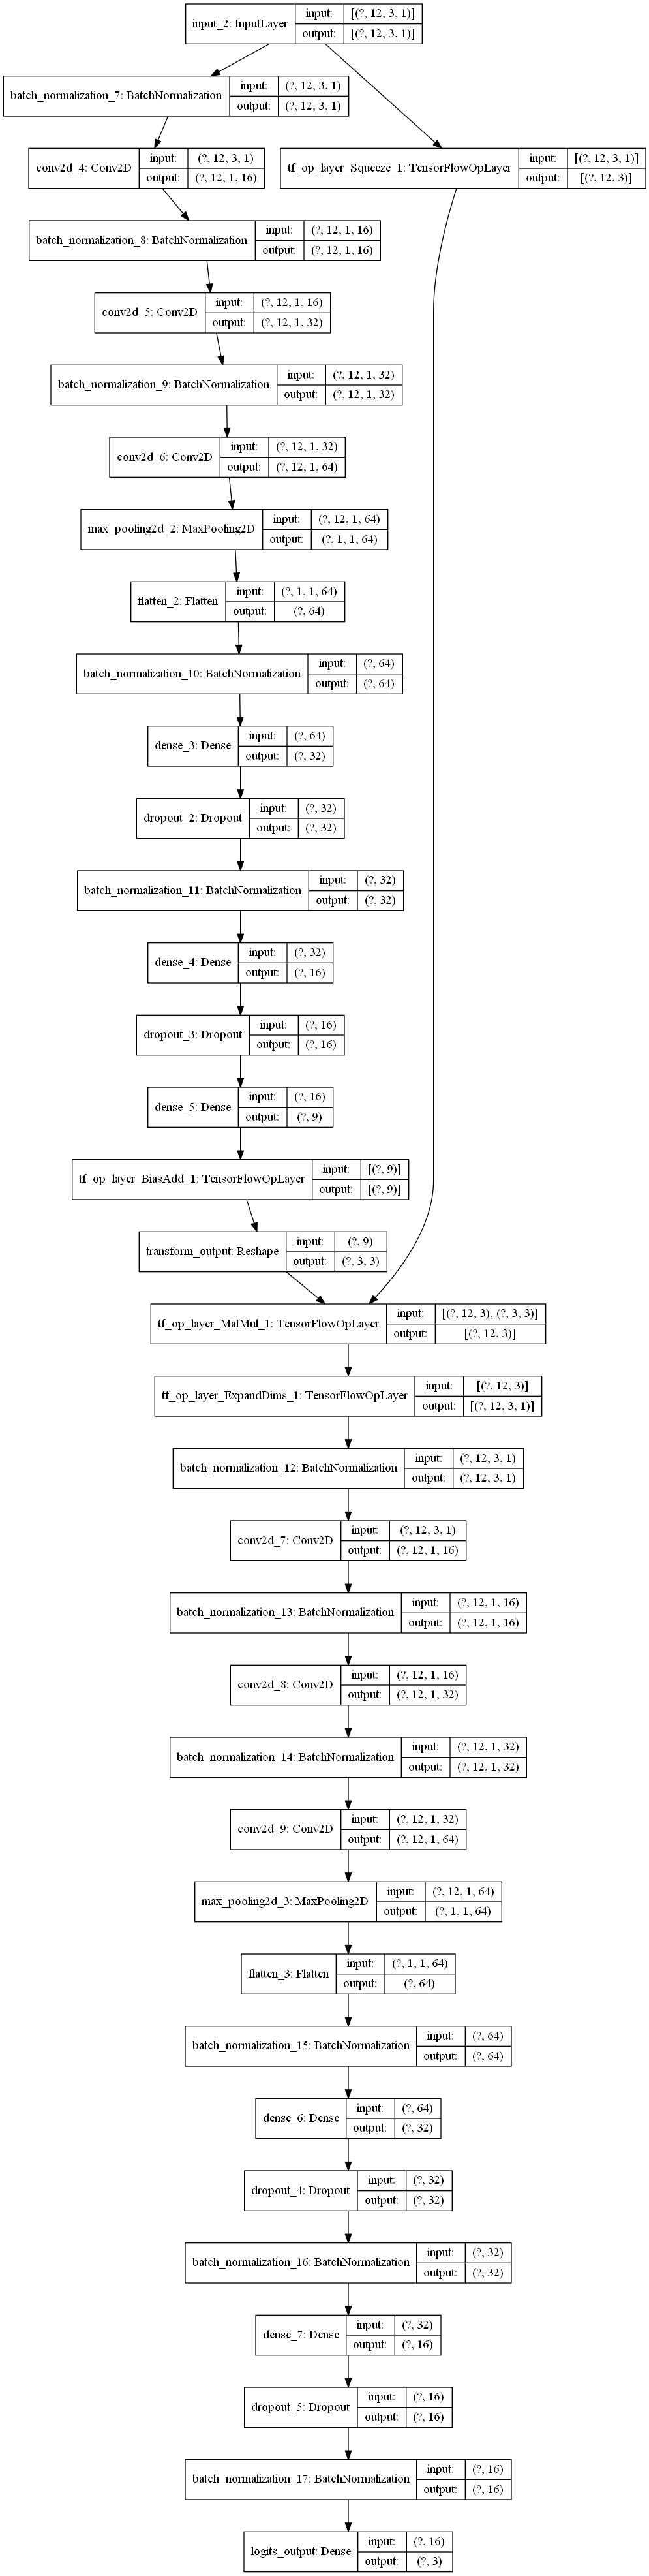

In [15]:
point_net = Model(inputs=inputs, outputs=[logits, transform])
point_net.summary()
tf.keras.utils.plot_model(point_net, to_file='point_net.png', show_shapes=True)

In [16]:
# 计算损失
def classify_loss(y_true, y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return tf.reduce_mean(loss)

def transform_loss(_, transform):
    mat_diff = tf.matmul(transform, tf.transpose(transform, perm=[0,2,1]))
    mat_diff -= tf.constant(np.eye(3), dtype=tf.float32)
    return tf.nn.l2_loss(mat_diff)

In [17]:
point_net.compile(
    optimizer='adam',
    loss={
        'logits_output':classify_loss,
        'transform_output':transform_loss},
    loss_weights={
        'logits_output':1.,
        'transform_output':0.05},
    metrics={
        'logits_output':'accuracy',
        'transform_output':[]}
)

In [18]:
history=point_net.fit(
        x=structure,
        y=[signature, signature],
        shuffle=True,
        epochs=100,
        validation_split=0.2,
        batch_size=batch_size)

.1364 - val_transform_output_loss: 0.0019 - val_logits_output_accuracy: 0.9414
Epoch 37/100
72000/72000 [==============================] - 21s 286us/sample - loss: 0.1508 - logits_output_loss: 0.1505 - transform_output_loss: 0.0051 - logits_output_accuracy: 0.9438 - val_loss: 0.1423 - val_logits_output_loss: 0.1422 - val_transform_output_loss: 0.0028 - val_logits_output_accuracy: 0.9364
Epoch 38/100
72000/72000 [==============================] - 24s 336us/sample - loss: 0.1503 - logits_output_loss: 0.1500 - transform_output_loss: 0.0060 - logits_output_accuracy: 0.9442 - val_loss: 0.1292 - val_logits_output_loss: 0.1285 - val_transform_output_loss: 0.0145 - val_logits_output_accuracy: 0.9439
Epoch 39/100
72000/72000 [==============================] - 21s 295us/sample - loss: 0.1485 - logits_output_loss: 0.1482 - transform_output_loss: 0.0062 - logits_output_accuracy: 0.9440 - val_loss: 0.1298 - val_logits_output_loss: 0.1297 - val_transform_output_loss: 0.0023 - val_logits_output_accur

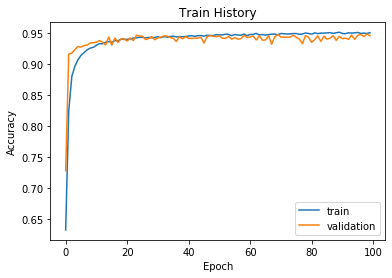

In [26]:
plt.plot(history.history['logits_output_accuracy'])
plt.plot(history.history['val_logits_output_accuracy'])
plt.title("Train History")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train','validation'])
plt.show()

In [27]:
point_net.save('point_net.h5')